# Example of using the PyRadiomics toolbox in Python

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

In [75]:
from __future__ import print_function
import six
import glob, os, sys  # needed navigate the system to get the input data
import time

# features are described at https://pyradiomics.readthedocs.io/en/latest/features.html
import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

import SimpleITK as sitk
import numpy as np
import pandas as pd
import cv2

# Display the images
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import seaborn as sns
print(f'seaborn version = {sns.__version__}')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

seaborn version = 0.11.1


In [94]:
ARG_SOURCE_PATH='/hdd/data/radioterapia/ciolaplata'
ARG_DICOM_AND_GAMMA_CSV = "codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv" # 7244 casos
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.all-texture-features-dumb.csv' # pyradiomics with dumb mask and GLCM features from scikit-image.
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.pyradiomics-texture-features-contours.csv' # pyradiomics only with contoured mask.
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.all-texture-features-contours.csv' # pyradiomics with contoured mask and GLCM features from scikit-image.
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.all-texture-features-contours-bounding-rectangle.csv' # pyradiomics with contoured mask and GLCM features from scikit-image with bounding rectangle.
ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.pyradiomics-contours-glcmsep-bounding-rectangles-opencv-contours.csv'
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.pyradiomics-contours-glcmsep-dumb-opencv-contours.csv'
ARG_SEED=23456 # t-SNE
# example image to extract features from
# image_filename = '1.3.6.1.4.1.9590.100.1.2.104687111612620525338811872261145275128.jpeg' # 1 contour
# image_filename = '1.3.6.1.4.1.9590.100.1.2.413026936412366497424912997123899479271.jpeg' # 1 contour
# image_filename = '1.3.6.1.4.1.9590.100.1.2.149022879910701913634657645393318300150.jpeg' # 3 contours with thres = 25, 2 with thres = 20
# image_filename = '1.3.6.1.4.1.9590.100.1.2.68178121113821334525403915874018401462.jpeg' # 4 contours with thres = 25, 1 with thres = 20
# image_filename = '1.3.6.1.4.1.9590.100.1.2.76296562210273102234514513081279675861.jpeg' # 3 contours with thres = 25, 1 also with thres = 20

image_filename = '1.3.6.1.4.1.9590.100.1.2.416170821113456993519232191293830059931.jpeg'

imagePath = os.path.join(ARG_SOURCE_PATH, '2017-opencv-jpeg', image_filename) # the above images are from 2017.

ARG_CONTOUR_MASK=True

ARG_EXTRACT_FEATURES=True
ARG_GLCM_SEPARATED_FEATURES_BOUNDING_BOX=True

### Setting up data

In [3]:
os.getcwd()

'/home/pablo/dev/radioterapia/fluence_maps/radiomics'

### Create dumb mask including _almost_ all pixels
If all pixels are included (0, 0, 255, 255) the mask is not created, so I created a (1, 1, 254, 254) mask.

In [4]:
def createDumbMask(image) -> sitk.SimpleITK.Image:
    image_size = image.GetSize()[::-1]
    point = (int(image_size[0]/2), int(image_size[1]/2))  # fill in the index of your point here
    # (254, 254) excluyo 1 pixel de cada lado
    roi_size = (image_size[0]-2, image_size[1]-2)  # x, y, z; uneven to ensure the point is really the center of your ROI

    ma_arr = np.zeros(image_size, dtype='uint8')

    # Compute lower and upper bound of the ROI
    L_x = point[0] - int((roi_size[0]) / 2)
    L_y = point[1] - int((roi_size[1]) / 2)

    U_x = point[0] + int((roi_size[0] - 1) / 2)
    U_y = point[1] + int((roi_size[1] - 1) / 2)

    # ensure the ROI stays within the image bounds
    L_x = max(0, L_x)
    L_y = max(0, L_y)

    U_x = min(image_size[1] - 1, U_x)
    U_y = min(image_size[0] - 1, U_y)

    print(L_x, L_y, U_x, U_y)

    # 'segment' the mask
    ma_arr[L_y:U_y + 1, L_x:U_x+1] = 1  # Add + 1 to each slice, as slicing is done from lower bound to, but not including, upper bound. Because we do want to include our upper bound, add + 1
    print(ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)
    ma.CopyInformation(image)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    #sitk.WriteImage(ma, maskPath, True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks
    return ma

### Create mask from countours

In [5]:
def createMaskFromContours(imagePath, debug=False) -> sitk.SimpleITK.Image:
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 20, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        plt.imshow(image, cmap = 'gray')

    ma_arr = image
    ma_arr = np.where(ma_arr == 255, 1, ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    # sitk.WriteImage(ma, maskPath, True)
    return ma

### Create bounding rectangle mask

In [6]:
# A bounding rectangle mask is of little use when extracting features with pyradiomics, because pyradiomics supports
# any mask so we use countour masks.
def createBoundingRectangleMask(imagePath, debug=False) -> sitk.SimpleITK.Image:
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 20, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # tomar el contorno de área máxima
    # loop over the contours
    cnt = contours[0]
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
            cnt = contours[i]
            
    x,y,w,h = cv2.boundingRect(cnt)
    bounding_box_area = w*h
    assert bounding_box_area != 0.0, f"Bounding box area for image {imagePath} is zero."

    # image2.shape = (256, 256)
    ma_arr = np.zeros(image2.shape, dtype='uint8')
    ma_arr[y:y+h, x:x+w] = 1
    ma = sitk.GetImageFromArray(ma_arr)
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

        plt.figure(figsize=(12, 12))

        plt.subplot(1,2,1)
        plt.imshow(image2, cmap = 'gray')
        plt.title("Contour mask")

        plt.subplot(1,2,2)
        cv2.rectangle(imgray, (x,y), (x+w,y+h), (128,0,0), 2)
        plt.imshow(imgray, cmap = 'gray')
        plt.title(f"Fluence map with bounding rectangle")

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    # sitk.WriteImage(ma, maskPath, True)
    return ma

### Crop image to bounding rectangle

In [7]:
# Use when extracting GLCM features using scikit-image only, not with pyradiomics
def cropToBoundingRectangle(imagePath, debug=False):
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 20, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # tomar el contorno de área máxima
    # loop over the contours
    cnt = contours[0]
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
            cnt = contours[i]
            
    x,y,w,h = cv2.boundingRect(cnt)
    bounding_box_area = w*h
    assert bounding_box_area != 0.0, f"Bounding box area for image {imagePath} is zero."

    # crop the image and make a copy of it before drawing the rectangle with cv2.rectangle()
    cropped_image = imgray[y:y+h, x:x+w].copy()
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

        plt.figure(figsize=(12, 12))

        plt.subplot(1,3,1)
        plt.imshow(image2, cmap = 'gray')
        plt.title(f"Contour mask {image2.shape}")

        plt.subplot(1,3,2)
        cv2.rectangle(imgray, (x,y), (x+w,y+h), (128,0,0), 2)
        plt.imshow(imgray, cmap = 'gray')
        plt.title(f"Fluence map\nwith bounding rectangle {imgray.shape}")

        plt.subplot(1,3,3)
        plt.imshow(cropped_image, cmap = 'gray')
        plt.title(f"Fluence map cropped\nto bounding rectangle {cropped_image.shape}")

    return cropped_image

In [8]:
# cropped_image = cropToBoundingRectangle(imagePath, True)

### Cell to play/experiment: find contours, find bounding rectangle, crop image, etc...
For experimentation: cv2.threshold() parameters differ from those in createMaskFromContours()

Contour features:
	Number of contours found = 2
	Contour area = 15097.5
	Bouding box area = 17316
	Contour perimeter = 482.978
	Convex hull area = 15445.0
	Extent = 0.8718814968814969
	Solidity = 0.9775008093234057
	Bounding rectangle (x=59, y=42, w=117, h=148)
(148, 117)


Text(0.5, 1.0, 'Fluence map cropped\nto bounding rectangle (117, 148)')

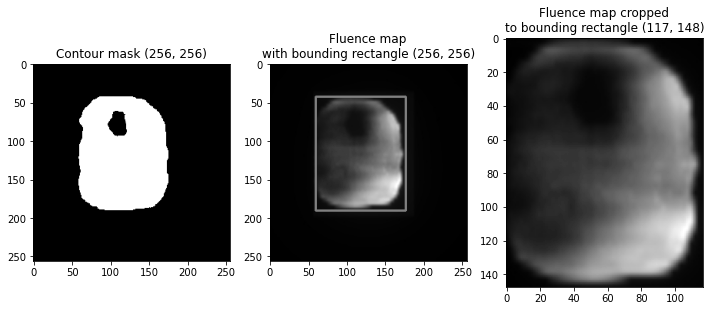

In [9]:
image = cv2.imread(imagePath) # (256, 256, 3)

# Finding Contours 
# Use a copy of the image e.g. imgray.copy() since findContours alters the image 
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # (256, 256, 3)

# Second output is our thresholded image.
# 25 is threshold, 255 is max value
ret, thresh = cv2.threshold(imgray, 20, 255, 0)

# contours is a Python list of all the contours in the image.
# Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# image2.shape = (256, 256)

# tomar el contorno de área máxima
# loop over the contours
cnt = contours[0]
for i in range(0, len(contours)):
    if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
        cnt = contours[i]

x,y,w,h = cv2.boundingRect(cnt)

print("Contour features:")
contour_area = cv2.contourArea(cnt)
contour_perimeter = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)
hull_area = cv2.contourArea(hull)
# extent = contour area / bounding box area
bounding_box_area = w*h
extent = contour_area / float(bounding_box_area)
# solidity = contour area / convex hull area
if hull_area != 0:
    solidity = contour_area / float(hull_area)

print(f"\tNumber of contours found = {len(contours)}")
print(f"\tContour area = {contour_area}")
print(f"\tBouding box area = {bounding_box_area}")
print(f'\tContour perimeter = {contour_perimeter:.3f}')
print(f'\tConvex hull area = {hull_area}')
print(f'\tExtent = {extent}')
print(f'\tSolidity = {solidity}')
print(f"\tBounding rectangle (x={x}, y={y}, w={w}, h={h})")


# crop the image and make a copy of it before drawing the rectangle with cv2.rectangle()
cropped_image = imgray[y:y+h, x:x+w].copy()
print(cropped_image.shape)

# draw a rectangle in the image
cv2.rectangle(imgray,(x,y),(x+w,y+h), (128,0,0),2)

plt.figure(figsize=(12, 12))

plt.subplot(1,3,1)
plt.imshow(image2, cmap = 'gray')
plt.title(f"Contour mask {image2.shape}")

plt.subplot(1,3,2)
plt.imshow(imgray, cmap = 'gray')
plt.title(f"Fluence map\nwith bounding rectangle {imgray.shape}")

plt.subplot(1,3,3)
plt.imshow(cropped_image, cmap = 'gray')
plt.title(f"Fluence map cropped\nto bounding rectangle ({cropped_image.shape[1]}, {cropped_image.shape[0]})")

In [10]:
len(image2)

256

In [11]:
# contours
print(len(contours))
# loop over the contours
for i in range(0, len(contours)):
    area = cv2.contourArea(contours[i])
    print(area)

2
15097.5
640.5


### Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

(256, 256)
/hdd/data/radioterapia/ciolaplata/2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.416170821113456993519232191293830059931.jpeg
Number of Contours found = 2
(256, 256)


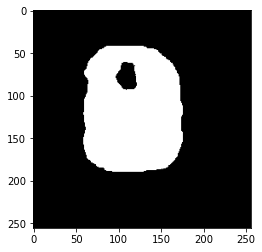

In [12]:
image_1 = sitk.ReadImage(imagePath)
# [::-1] es iterable[inicio:fin:paso]
image_size = image_1.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x
print(image_size)


if ARG_CONTOUR_MASK:
    label_1 = createMaskFromContours(imagePath, debug=True)
else:
    label_1 = createMask(image_1)

image_size = label_1.GetSize()[::-1]
print(image_size)

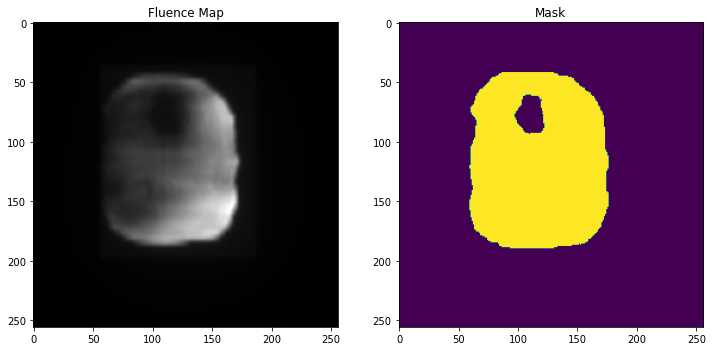

In [13]:
plt.figure(figsize=(12,12))

# 1 row, 2 columns, plot 1
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[:,:], cmap="gray")
plt.title("Fluence Map")
# 1 row, 2 columns, plot 2
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[:,:])        
plt.title("Mask")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object from the parameters set in `Params.yaml`.  Then generate features for the two images.

In [14]:
# Additonally, store the location of the example parameter file, stored in \pyradiomics\examples/exampleSettings
paramPath = os.path.join('.', 'rtParams.yaml')
print('Parameter file, absolute path:', os.path.abspath(paramPath))

Parameter file, absolute path: /home/pablo/dev/radioterapia/fluence_maps/radiomics/rtParams.yaml


### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are three possibilities:

1. Use defaults, don't define custom settings

2. Define parameters in a dictionary, control filters and features after initialisation

3. Use a parameter file

##### Method 3, using a parameter file

In [15]:
# radiomics.setVerbosity(10) # 10: Log messages of level “DEBUG” and up are printed (i.e. all log messages)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'MeanAbsoluteDeviation', 'Mean', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance'], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'MCC', 'Idmn', 'Id', 'Idn', 'InverseVarianc

### Extract features using pyradiomics

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [16]:
# imageFilepath – SimpleITK Image, or string pointing to image file location
# maskFilepath – SimpleITK Image, or string pointing to labelmap file location
result = extractor.execute(image_1, label_1)

In [17]:
print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
print('')
print('Calculated features')
for key, value in six.iteritems(result):
    print('\t', key, ':', value)

Result type: <class 'collections.OrderedDict'>

Calculated features
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.19.2
	 diagnostics_Versions_SimpleITK : 2.0.2
	 diagnostics_Versions_PyWavelet : 1.1.1
	 diagnostics_Versions_Python : 3.7.5
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : 2a92a1164fdf0f2726d99a1985e5d03bcad7f797
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 diagnostics_Image-original_Size : (256, 256)
	 diagnostics_Image-o

### Extract GLCM features using scikit-image

In [18]:
# The GLCM Tutorial Home Page,
#       http://www.fp.ucalgary.ca/mhallbey/tutorial.htm       
from skimage.feature import greycomatrix, greycoprops
from skimage import io  

image = io.imread(imagePath)

xs = []
ys = []
# Todas las métricas para las distintas distancias están correlacionadas con r > 0.9, entonces sólo uso d = 5
# las métrics 'energy' y 'ASM' tienen una correlación r = 1.0 para todas las distancias y todos los ángulos, entonces sólo uso d = 5 y a = 0
# distances = [1, 2, 4, 8] # d: list of pixel pair distance offsets.
distances = [5]
angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians. Para todas las métricas excepto 'energy' y 'ASM'
a_degress = (np.array(angles)*180/np.pi).astype(np.int)
glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                    symmetric=True, normed=True)
xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
ys.append(greycoprops(glcm, 'correlation')[0, 0])

In [19]:
glcm[:, :, 0, 3].shape

(256, 256)

In [20]:
# results : 2-D ndarray
#    2-dimensional array. `results[d, a]` is the property 'prop' for
#    the d'th distance and the a'th angle.
# ex.: results[2, 1] is results[d=4, a=45]
greycoprops(glcm, 'dissimilarity')

array([[4.04379358, 5.01081822, 3.82737799, 4.5417454 ]])

In [21]:
def extract_gclm_separated(image, bb=False):
    distances = [5] # d: list of pixel pair distance offsets.
    angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians.
    a_degress = (np.array(angles)*180/np.pi).astype(np.int)
    
    # la matriz se calcula para todas las distancias y ángulos,
    # pero las métricas no, sólo para las distancias y ángulos de interés.
    glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    glcm_dict = {}
    features = ['contrast', 'dissimilarity', 'homogeneity', 'correlation']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                if bb:
                    name = 'glcmsepbb_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    
    angles = [0]
    
    features = ['energy', 'ASM']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                if bb:
                    name = 'glcmsepbb_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    return glcm_dict

In [22]:
glcm_dict=extract_gclm_separated(image)
print('Se extrajeron {} GCLM features separadas calculadas en toda la imagen.'.format(len([*glcm_dict]))) # https://www.python.org/dev/peps/pep-0448/
glcm_dict

Se extrajeron 18 GCLM features separadas calculadas en toda la imagen.


{'glcmsep_contrast_5_0': 187.43553909362538,
 'glcmsep_contrast_5_45': 237.2238126732173,
 'glcmsep_contrast_5_90': 154.16745517928265,
 'glcmsep_contrast_5_135': 206.80305177626602,
 'glcmsep_dissimilarity_5_0': 4.043793575697207,
 'glcmsep_dissimilarity_5_45': 5.0108182161753545,
 'glcmsep_dissimilarity_5_90': 3.8273779880478074,
 'glcmsep_dissimilarity_5_135': 4.5417454018644525,
 'glcmsep_homogeneity_5_0': 0.6629817921620005,
 'glcmsep_homogeneity_5_45': 0.6250611792727989,
 'glcmsep_homogeneity_5_90': 0.680722728159502,
 'glcmsep_homogeneity_5_135': 0.6262437661545088,
 'glcmsep_correlation_5_0': 0.9507093812780318,
 'glcmsep_correlation_5_45': 0.938170004681305,
 'glcmsep_correlation_5_90': 0.9594592203906886,
 'glcmsep_correlation_5_135': 0.9460988693372353,
 'glcmsep_energy_5_0': 0.36689262716407234,
 'glcmsep_ASM_5_0': 0.13461019986735498}

In [23]:
glcmbb_dict=extract_gclm_separated(cropToBoundingRectangle(imagePath), bb=True)
print('Se extrajeron {} GCLM features separadas calculadas en el bounding rectangle.'.format(len([*glcmbb_dict]))) # https://www.python.org/dev/peps/pep-0448/
glcmbb_dict

Se extrajeron 18 GCLM features separadas calculadas en el bounding rectangle.


{'glcmsepbb_contrast_5_0': 689.7873431467187,
 'glcmsepbb_contrast_5_45': 879.2716937069822,
 'glcmsepbb_contrast_5_90': 531.4078058693439,
 'glcmsepbb_contrast_5_135': 760.1299778761058,
 'glcmsepbb_dissimilarity_5_0': 13.512125965250952,
 'glcmsepbb_dissimilarity_5_45': 16.582780235988203,
 'glcmsepbb_dissimilarity_5_90': 12.41790687944533,
 'glcmsepbb_dissimilarity_5_135': 14.735312192723706,
 'glcmsepbb_homogeneity_5_0': 0.13341642568742143,
 'glcmsepbb_homogeneity_5_45': 0.1230629181324918,
 'glcmsepbb_homogeneity_5_90': 0.16528036888993797,
 'glcmsepbb_homogeneity_5_135': 0.13267535992198481,
 'glcmsepbb_correlation_5_0': 0.8902128417646707,
 'glcmsepbb_correlation_5_45': 0.8600662091457796,
 'glcmsepbb_correlation_5_90': 0.9158922101111718,
 'glcmsepbb_correlation_5_135': 0.8790337141123813,
 'glcmsepbb_energy_5_0': 0.021058512087216066,
 'glcmsepbb_ASM_5_0': 0.00044346093132742513}

In [24]:
def extractContourFeatures(imagePath):
    feat_dict = {}
    
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 25, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    assert len(contours) != 0.0, f"Number of contour for image {imagePath} is zero."
    
    # tomar el contorno de área máxima
    # loop over the contours
    cnt = contours[0]
    for i in range(0, len(contours)):
        if cv2.contourArea(contours[i]) > cv2.contourArea(cnt):
            cnt = contours[i]
        
    x,y,w,h = cv2.boundingRect(cnt)

    contour_area = cv2.contourArea(cnt)
    contour_perimeter = cv2.arcLength(cnt, True)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    assert hull_area != 0.0, f"Convex hull area for image {imagePath} is zero."
    bounding_box_area = w*h
    assert bounding_box_area != 0.0, f"Bounding box area for image {imagePath} is zero."
    # extent = contour area / bounding box area
    extent = contour_area / float(bounding_box_area)
    # solidity = contour area / convex hull area
    if hull_area != 0:
        solidity = contour_area / float(hull_area)
    
    feat_dict = {
        'contour_number' : len(contours)
        , 'contour_area' : contour_area
        , 'contour_perimeter' : contour_perimeter
        , 'contour_bounding_box_area' : bounding_box_area
        , 'contour_hull_area' : hull_area
        , 'contour_extent' : extent
        , 'contour_solidity' : solidity
    }
    
    return feat_dict

In [25]:
contour_dict=extractContourFeatures(imagePath)
print('Se extrajeron {} contour features.'.format(len([*contour_dict])))
contour_dict

Se extrajeron 7 contour features.


{'contour_number': 3,
 'contour_area': 14439.0,
 'contour_perimeter': 491.8477599620819,
 'contour_bounding_box_area': 17020,
 'contour_hull_area': 14944.0,
 'contour_extent': 0.8483548766157462,
 'contour_solidity': 0.9662071734475375}

In [26]:
def getFeatureNames(result, glcm_dict, glcmbb_dict, contour_dict):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    # le dejo el prefijo 'original_' y se lo saco después
    feature_names = [key for key in result.keys() if key.startswith('original_')]
    feature_names = feature_names + [*glcm_dict] + [*glcmbb_dict] + [*contour_dict]
    return feature_names

In [27]:
def getRenamedFeatureNames(result, glcm_dict, glcmbb_dict, contour_dict):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # remuevo el prefijo 'original_'
    feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    feature_names = feature_names + [*glcm_dict] + [*glcmbb_dict] + [*contour_dict]
    return feature_names

In [28]:
renamed_feature_names = getRenamedFeatureNames(result, glcm_dict, glcmbb_dict, contour_dict)
renamed_feature_names

['firstorder_10Percentile',
 'firstorder_90Percentile',
 'firstorder_Energy',
 'firstorder_Entropy',
 'firstorder_InterquartileRange',
 'firstorder_Kurtosis',
 'firstorder_MeanAbsoluteDeviation',
 'firstorder_Mean',
 'firstorder_Range',
 'firstorder_RobustMeanAbsoluteDeviation',
 'firstorder_RootMeanSquared',
 'firstorder_Skewness',
 'firstorder_TotalEnergy',
 'firstorder_Uniformity',
 'firstorder_Variance',
 'glcm_Autocorrelation',
 'glcm_JointAverage',
 'glcm_ClusterProminence',
 'glcm_ClusterShade',
 'glcm_ClusterTendency',
 'glcm_Contrast',
 'glcm_Correlation',
 'glcm_DifferenceAverage',
 'glcm_DifferenceEntropy',
 'glcm_DifferenceVariance',
 'glcm_JointEnergy',
 'glcm_JointEntropy',
 'glcm_Imc1',
 'glcm_Imc2',
 'glcm_Idm',
 'glcm_MCC',
 'glcm_Idmn',
 'glcm_Id',
 'glcm_Idn',
 'glcm_InverseVariance',
 'glcm_MaximumProbability',
 'glcm_SumEntropy',
 'glcm_SumSquares',
 'glrlm_GrayLevelNonUniformity',
 'glrlm_GrayLevelNonUniformityNormalized',
 'glrlm_GrayLevelVariance',
 'glrlm_HighG

## Extract features for each .jpeg file in folder and generate .csv with features

In [29]:
def build_jpeg_filename(base, year, filename):
    return os.path.join(base, year + '-opencv-jpeg', filename + '.jpeg')

In [30]:
def extractFeatures(df):
    total = len(df)
    i = 0
    for file in df['jpeg_full_filepath'].values:
        try:
            image = sitk.ReadImage(file)
            shape = image.GetSize()[::-1]
            assert len(shape) == 2, "JPEG files are not grey level (i.e.: do not have 2 channels)"
            assert shape[0] == 256 and shape[1] == 256, "JPEG files are not of size 256x256"

            if ARG_CONTOUR_MASK:
                # generar la máscara para cada imagen
                mask = createMaskFromContours(file)
            
            result = extractor.execute(image, mask)
            for key in result.keys():
                if key.startswith('original_'):
                    df.loc[i, key] = result.get(key)

            # read image file again using scikit-image
            image = io.imread(file)
            glcm_dict=extract_gclm_separated(image)
            for key in glcm_dict.keys():
                df.loc[i, key] = glcm_dict.get(key)

            if ARG_GLCM_SEPARATED_FEATURES_BOUNDING_BOX:
                glcm_dict=extract_gclm_separated(cropToBoundingRectangle(file), bb=True)
                for key in glcm_dict.keys():
                    df.loc[i, key] = glcm_dict.get(key)
                    
            contour_dict = extractContourFeatures(file)
            for key in contour_dict.keys():
                df.loc[i, key] = contour_dict.get(key)
                        
            sys.stdout.write('\r>> Features extracted for image %d/%d.' % (i+1, total))
            sys.stdout.flush()
            i += 1

        except OSError as err:
            print('Could not extract features for file {}, error: {}'.format(file, err))

    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return df

In [31]:
if ARG_EXTRACT_FEATURES:
    source_folder = ARG_SOURCE_PATH

    gamma_csv = os.path.join(source_folder, ARG_DICOM_AND_GAMMA_CSV)
    texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
    df_dcm_in = pd.read_csv(gamma_csv, sep=';', delimiter=None, header=0)
    N = len(df_dcm_in)
    feature_names = getFeatureNames(result, glcm_dict, glcmbb_dict, contour_dict)
    print("Se extraerán {} features para cada uno de los {} archivos JPEG en {}, y se escribirán en {}."
          .format(len(feature_names), N, gamma_csv, texture_features_csv))

    # agrego una columna constante al dataframe para hacer más simple el armado del full file path de los archivos dicom
    df_dcm_in['base_dir'] = source_folder

    df_features_out = pd.DataFrame(columns=['jpeg_full_filepath', 'gamma_index'] + feature_names)
    df_features_out['jpeg_full_filepath'] = [build_jpeg_filename(row[0], str(row[1]), row[2]) for row in df_dcm_in[['base_dir', 'año', 'fluencia calculada']].values]
    df_features_out['gamma_index'] = df_dcm_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)


    # df_features_out.loc[:, ['jpeg_full_filepath','gamma_index','firstorder_10Percentile','glszm_LowGrayLevelZoneEmphasis']]
    df_features_out[['jpeg_full_filepath','gamma_index','original_firstorder_10Percentile','original_glszm_LowGrayLevelZoneEmphasis']]

    # extract features
    df_features = extractFeatures(df_features_out)

    df_features.columns= ['jpeg_full_filepath', 'gamma_index'] + renamed_feature_names

    df_features.to_csv(texture_features_csv, index=False)
    print(f'Texture features .csv file saved to {texture_features_csv}.\n')

Se extraerán 132 features para cada uno de los 7244 archivos JPEG en /hdd/data/radioterapia/ciolaplata/codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv, y se escribirán en /hdd/data/radioterapia/ciolaplata/2019-2018-2017.pyradiomics-contours-glcmsep-bounding-rectangles-opencv-contours.csv.
>> Features extracted for image 7244/7244.
Texture features .csv file saved to /hdd/data/radioterapia/ciolaplata/2019-2018-2017.pyradiomics-contours-glcmsep-bounding-rectangles-opencv-contours.csv.



## Load features from .csv

In [29]:
def gamma_interval(gamma_value):
    if gamma_value < 95.0:
        interval = "< 95%"
    elif gamma_value >= 95.0:
        interval = ">= 95%"
    
    return interval

In [30]:
texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
print(f'Se leyeron los texture features de {texture_features_csv}')
df_features_copy = pd.read_csv(texture_features_csv, delimiter=None, header=0)
df_features_copy['gamma interval'] = [gamma_interval(value) for value in df_features_copy['gamma_index']]
df_features_copy

Se leyeron los texture features de /hdd/data/radioterapia/ciolaplata/2019-2018-2017.pyradiomics-contours-glcmsep-bounding-rectangles-opencv-contours.csv


,jpeg_full_filepath,gamma_index,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_MeanAbsoluteDeviation,firstorder_Mean,...,glcmsepbb_energy_5_0,glcmsepbb_ASM_5_0,contour_number,contour_area,contour_perimeter,contour_bounding_box_area,contour_hull_area,contour_extent,contour_solidity,gamma interval
0,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.161700,33.0,178.0,168680673.0,3.569803,85.0,2.306038,45.425796,106.660707,...,0.028740,0.000826,3,11041.5,597.203098,14832,12807.0,0.744438,0.862146,< 95%
1,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.333400,45.0,142.0,137806511.0,3.254422,45.0,4.021815,30.412098,102.467573,...,0.049090,0.002410,1,10716.0,509.847760,16074,12336.0,0.666667,0.868677,< 95%
2,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.338600,38.0,188.0,99202055.0,3.448990,50.0,3.233402,38.807941,99.023288,...,0.073987,0.005474,1,7545.5,414.551297,12319,8415.5,0.612509,0.896619,< 95%
3,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.513800,33.0,154.0,127875723.0,3.436584,62.0,3.453515,36.511564,90.137464,...,0.053186,0.002829,2,11760.5,576.232536,17600,13959.5,0.668210,0.842473,< 95%
4,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.604800,33.0,166.0,116063095.0,3.482825,60.0,2.990402,37.522368,99.402481,...,0.047420,0.002249,1,8799.0,482.936072,13114,10171.0,0.670962,0.865107,< 95%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7239,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.908812,35.0,218.0,82800280.0,3.840632,115.0,1.795429,57.039892,131.401723,...,0.060869,0.003705,1,3535.0,283.764499,6177,4056.5,0.572284,0.871441,>= 95%
7240,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.916852,32.0,191.0,74048992.0,3.740280,105.0,1.873703,51.769900,115.088970,...,0.046882,0.002198,1,4032.0,335.906635,6390,4739.5,0.630986,0.850723,>= 95%
7241,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.922824,27.0,209.0,116472658.0,3.751823,109.0,1.891362,55.555505,126.879301,...,0.052675,0.002775,2,4500.0,277.622364,6300,4748.5,0.714286,0.947668,>= 95%
7242,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.935760,24.0,185.6,12730023.0,3.466064,90.0,2.880765,51.637490,85.059389,...,0.040034,0.001603,3,722.5,117.497474,1156,803.5,0.625000,0.899191,>= 95%


In [31]:
counts = df_features_copy.groupby(['gamma interval'])['jpeg_full_filepath'].count()
counts['< 95%'], counts['>= 95%']

(1596, 5648)

In [32]:
feature_names_in_csv = df_features_copy.columns[2:-1]
print(f'Number of features = {len(feature_names_in_csv)}')
feature_names_in_csv

Number of features = 132


Index(['firstorder_10Percentile', 'firstorder_90Percentile',
       'firstorder_Energy', 'firstorder_Entropy',
       'firstorder_InterquartileRange', 'firstorder_Kurtosis',
       'firstorder_MeanAbsoluteDeviation', 'firstorder_Mean',
       'firstorder_Range', 'firstorder_RobustMeanAbsoluteDeviation',
       ...
       'glcmsepbb_correlation_5_135', 'glcmsepbb_energy_5_0',
       'glcmsepbb_ASM_5_0', 'contour_number', 'contour_area',
       'contour_perimeter', 'contour_bounding_box_area', 'contour_hull_area',
       'contour_extent', 'contour_solidity'],
      dtype='object', length=132)

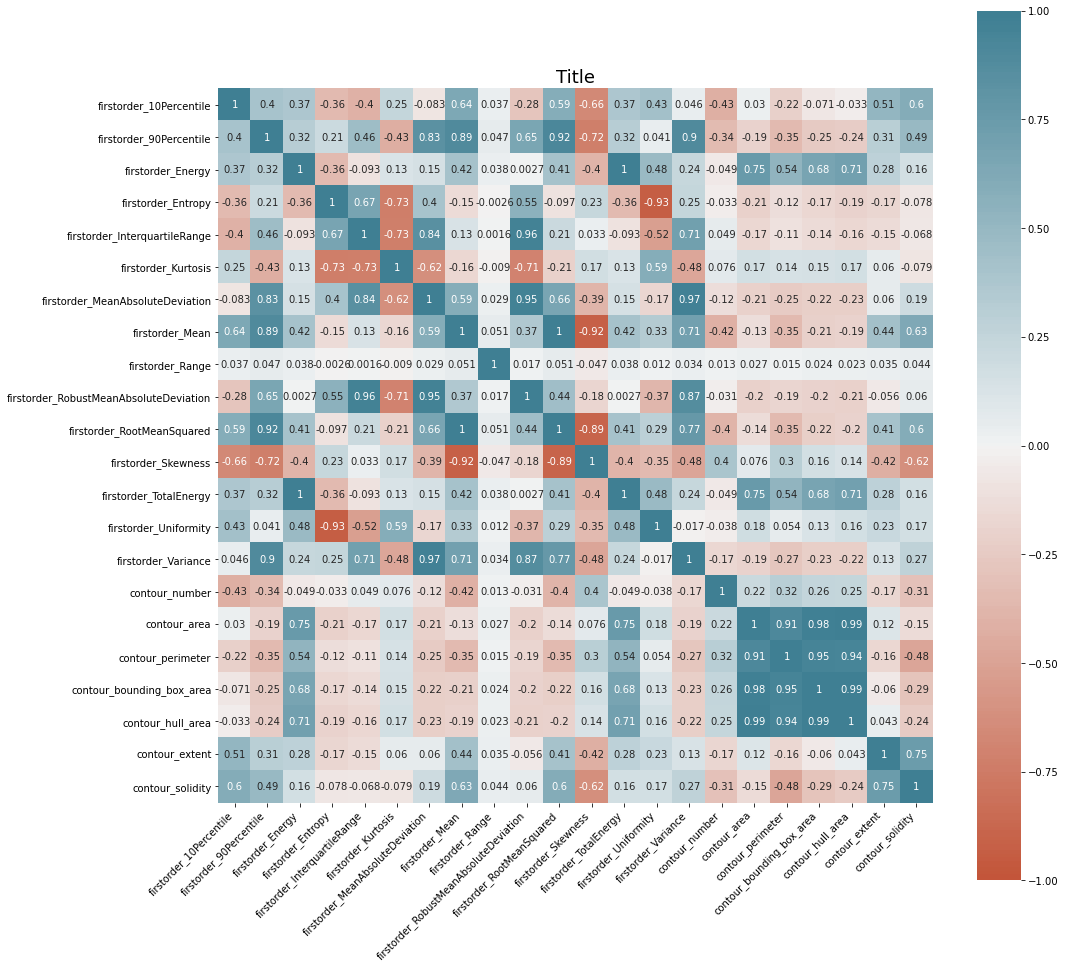

In [33]:
features_of_interest = [name for name in feature_names_in_csv if (name.startswith('contour_') or name.startswith('firstorder_'))]

corr = df_features_copy[features_of_interest].corr()

fig_dims = (16, 16)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0, 0.5, 'Count')

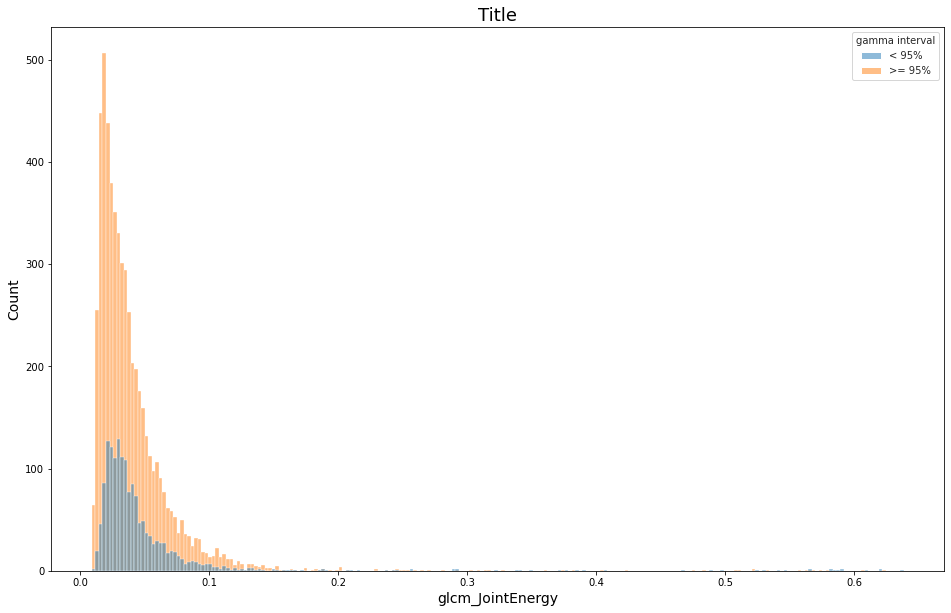

In [37]:
feature = 'glcm_JointEnergy'
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

sns.set_style("whitegrid")
ax = sns.histplot(data=df_features_copy, x=feature, hue='gamma interval')
ax.set_xlabel(feature, fontsize=14)
ax.set_ylabel("Count", fontsize=14)

## Compute PCA and t-SNE on texture features

In [38]:
# https://erdem.pl/2020/04/t-sne-clearly-explained
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

features_of_interest = [name for name in feature_names_in_csv if (name.startswith('glrlm_')

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_features_copy[features_of_interest].values)
df_features_copy['1st component'] = pca_result[:,0]
df_features_copy['2nd component'] = pca_result[:,1] 
df_features_copy['3rd component'] = pca_result[:,2]

np.set_printoptions(precision=2, suppress=True)
print('Varianza explicada por 3 componentes principales (%): {}'.format(pca.explained_variance_ratio_*100))

variance = 0.90 # explicar 80% de la varianza
pca2 = PCA(n_components=variance, svd_solver='full')
pca_result2 = pca2.fit_transform(df_features_copy[features_of_interest].values)
print(f"Cantidad de componentes para explicar un {variance*100}% de la varianza: {pca2.n_components_}")

Varianza explicada por 3 componentes principales (%): [99.95  0.05  0.  ]
Cantidad de componentes para explicar un 90.0% de la varianza: 1


In [39]:
features_of_interest

['glrlm_GrayLevelNonUniformity',
 'glrlm_GrayLevelNonUniformityNormalized',
 'glrlm_GrayLevelVariance',
 'glrlm_HighGrayLevelRunEmphasis',
 'glrlm_LongRunEmphasis',
 'glrlm_LongRunHighGrayLevelEmphasis',
 'glrlm_LongRunLowGrayLevelEmphasis',
 'glrlm_LowGrayLevelRunEmphasis',
 'glrlm_RunEntropy',
 'glrlm_RunLengthNonUniformity',
 'glrlm_RunLengthNonUniformityNormalized',
 'glrlm_RunPercentage',
 'glrlm_RunVariance',
 'glrlm_ShortRunEmphasis',
 'glrlm_ShortRunHighGrayLevelEmphasis',
 'glrlm_ShortRunLowGrayLevelEmphasis']

<AxesSubplot:xlabel='1st component', ylabel='2nd component'>

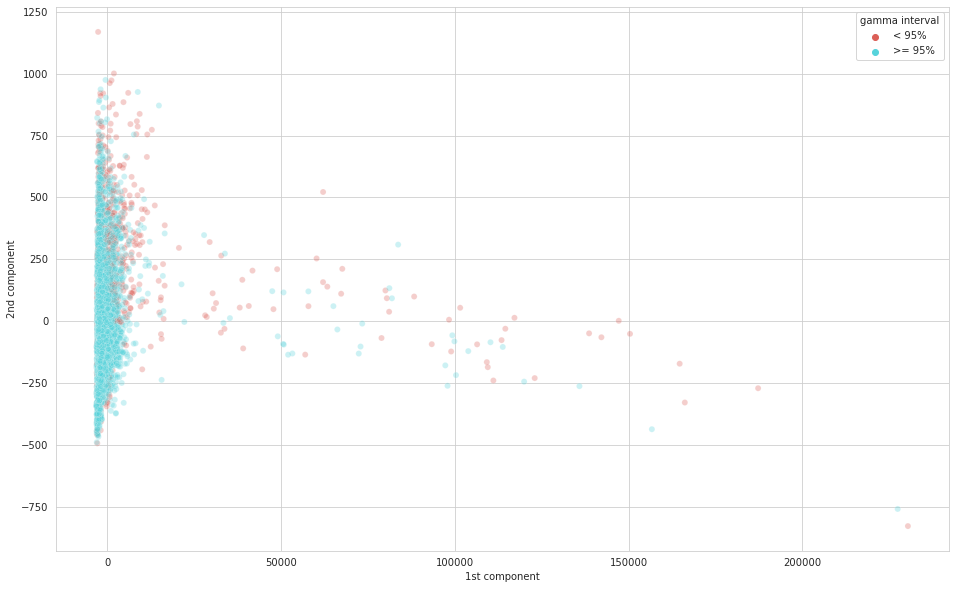

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="1st component", y="2nd component",
    hue='gamma interval',
    data=df_features_copy,
    legend="full",
    alpha=0.3,
    # palette=sns.color_palette("hls", 2)
    palette=sns.hls_palette(2)
)

In [52]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, random_state=ARG_SEED)
tsne_results = tsne.fit_transform(df_features_copy[features_of_interest].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7244 samples in 0.008s...
[t-SNE] Computed neighbors for 7244 samples in 0.387s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7244
[t-SNE] Computed conditional probabilities for sample 2000 / 7244
[t-SNE] Computed conditional probabilities for sample 3000 / 7244
[t-SNE] Computed conditional probabilities for sample 4000 / 7244
[t-SNE] Computed conditional probabilities for sample 5000 / 7244
[t-SNE] Computed conditional probabilities for sample 6000 / 7244
[t-SNE] Computed conditional probabilities for sample 7000 / 7244
[t-SNE] Computed conditional probabilities for sample 7244 / 7244
[t-SNE] Mean sigma: 16.201713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.610809
[t-SNE] KL divergence after 500 iterations: 0.685687
t-SNE done! Time elapsed: 24.451733112335205 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

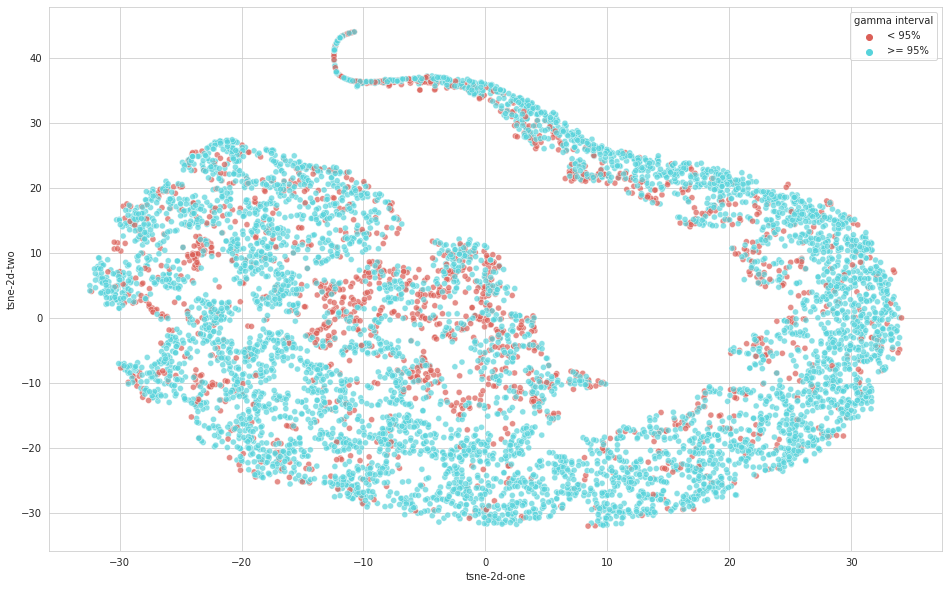

In [53]:
df_features_copy['tsne-2d-one'] = tsne_results[:,0]
df_features_copy['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='gamma interval',
    palette=sns.hls_palette(2),
    data=df_features_copy,
    legend="full",
    alpha=0.7
)

In [34]:
import xgboost as xgb
print('XGBoost version = {}'.format(xgb.__version__))

XGBoost version = 1.3.3


## Train an XGBoost model with extracted CNN features in 2019+2017
Hago cross-validation usando XGBoost directamente. Para cada métrica se informa, en cada iteración, la media y el desvío standard entre los k folds separados con '+', ej.: **test-rmse:71.88373+1.10987**.

CV con el Learning API (core) soporta early stopping.

In [98]:
# excluir mapas de 2018 para comparar con la CNN presentada en ASTRO:
X = df_features_copy
X['year2018'] = [path.find('2018-opencv') != -1 for path in X['jpeg_full_filepath']]
X = X[~X['year2018']]
y = X['gamma_index']

features_of_interest = feature_names_in_csv # all features extracted so far help to improve performance in validation set.
features_of_interest = [name for name in feature_names_in_csv if not (name.startswith('glcmsep_'))]
                                                                   
X = X[features_of_interest]
print(X.shape, y.shape)

X_train_cv = X
y_train_cv = y
print(X_train_cv.shape, y_train_cv.shape)

dtrain_cv = xgb.DMatrix(data=X_train_cv, label=y_train_cv)
print(f'DMatrix cols: {dtrain_cv.num_col()} rows: {dtrain_cv.num_row()}')

(4268, 114) (4268,)
(4268, 114) (4268,)
DMatrix cols: 114 rows: 4268


In [99]:
features_of_interest

['firstorder_10Percentile',
 'firstorder_90Percentile',
 'firstorder_Energy',
 'firstorder_Entropy',
 'firstorder_InterquartileRange',
 'firstorder_Kurtosis',
 'firstorder_MeanAbsoluteDeviation',
 'firstorder_Mean',
 'firstorder_Range',
 'firstorder_RobustMeanAbsoluteDeviation',
 'firstorder_RootMeanSquared',
 'firstorder_Skewness',
 'firstorder_TotalEnergy',
 'firstorder_Uniformity',
 'firstorder_Variance',
 'glcm_Autocorrelation',
 'glcm_JointAverage',
 'glcm_ClusterProminence',
 'glcm_ClusterShade',
 'glcm_ClusterTendency',
 'glcm_Contrast',
 'glcm_Correlation',
 'glcm_DifferenceAverage',
 'glcm_DifferenceEntropy',
 'glcm_DifferenceVariance',
 'glcm_JointEnergy',
 'glcm_JointEntropy',
 'glcm_Imc1',
 'glcm_Imc2',
 'glcm_Idm',
 'glcm_MCC',
 'glcm_Idmn',
 'glcm_Id',
 'glcm_Idn',
 'glcm_InverseVariance',
 'glcm_MaximumProbability',
 'glcm_SumEntropy',
 'glcm_SumSquares',
 'glrlm_GrayLevelNonUniformity',
 'glrlm_GrayLevelNonUniformityNormalized',
 'glrlm_GrayLevelVariance',
 'glrlm_HighG

### Resultados con 2019+2018+2017
**Dataset:** '2019-2018-2017.all-texture-features-dumb.csv'

_train-mae:1.11119+0.00764	test-rmse:3.13041+0.08029	test-mae:1.94695+0.03_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 25
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.all-texture-features-dumb.csv' (excluding 2018)

_[489]	train-rmse:1.27878+0.02592	train-mae:0.90220+0.01639	test-rmse:2.98198+0.14417	test-mae:1.92271+0.07347_
```python
param = {'max_depth': 5 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.pyradiomics-texture-features-contours.csv' (excluding 2018)

_[318]	train-rmse:1.45937+0.03612	train-mae:1.01763+0.02408	test-rmse:2.88731+0.09014	test-mae:1.86241+0.04941_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         , 'colsample_bynode': 0.3
         # , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.all-texture-features-contours.csv' (excluding 2018)

_[381]	train-rmse:1.16212+0.01242	train-mae:0.81353+0.00677	test-rmse:2.83408+0.05123	test-mae:1.80370+0.03335_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017 (las GLCM features extraídas con scikit-image aportan más si se calculan sobre todo el mapa y no en el bounding rectangle)
**Dataset:** '2019-2018-2017.all-texture-features-contours-bounding-rectangle.csv' (excluding 2018)
**Nota:** no mejoró sino que empeoró la performance respecto a '2019-2018-2017.all-texture-features-contours.csv' (excluding 2018)'

_[337]	train-rmse:1.27227+0.04079	train-mae:0.88739+0.02571	test-rmse:2.87241+0.07535	test-mae:1.83329+0.04732_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

In [123]:
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'learning_rate': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3 # related to 'min_child_weight'
         # , 'colsample_bynode': 0.25
         , 'colsample_bylevel' : 0.3
         , 'reg_lambda': 2 # L2 regularization
         , 'reg_alpha': 2 # L1 regularization
         , 'min_split_loss': 0.01
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }

In [114]:
print('running cross validation...')
bst = xgb.cv(param, dtrain_cv, nfold=5, num_boost_round=1000, early_stopping_rounds=10, metrics=['rmse', 'mae'],
             seed=ARG_SEED, shuffle=True, verbose_eval=True)

running cross validation...
[0]	train-rmse:90.55866+0.02945	train-mae:90.44141+0.03106	test-rmse:90.55873+0.12440	test-mae:90.44149+0.13095
[1]	train-rmse:86.04317+0.02777	train-mae:85.92459+0.02951	test-rmse:86.04420+0.12337	test-mae:85.92551+0.13011
[2]	train-rmse:81.75358+0.02631	train-mae:81.63334+0.02803	test-rmse:81.75474+0.12086	test-mae:81.63435+0.12791
[3]	train-rmse:77.67848+0.02480	train-mae:77.55639+0.02664	test-rmse:77.68102+0.12080	test-mae:77.55870+0.12801
[4]	train-rmse:73.80734+0.02343	train-mae:73.68306+0.02530	test-rmse:73.81111+0.11836	test-mae:73.68665+0.12591
[5]	train-rmse:70.12982+0.02209	train-mae:70.00317+0.02404	test-rmse:70.13254+0.11681	test-mae:70.00549+0.12453
[6]	train-rmse:66.63643+0.02078	train-mae:66.50707+0.02284	test-rmse:66.64080+0.11616	test-mae:66.51099+0.12409
[7]	train-rmse:63.31778+0.01969	train-mae:63.18555+0.02169	test-rmse:63.32251+0.11293	test-mae:63.18965+0.12111
[8]	train-rmse:60.16527+0.01855	train-mae:60.02996+0.02061	test-rmse:60.1703

[74]	train-rmse:3.17554+0.02324	train-mae:2.73653+0.01959	test-rmse:3.61684+0.05855	test-mae:3.00723+0.03717
[75]	train-rmse:3.09901+0.02248	train-mae:2.65442+0.01880	test-rmse:3.55536+0.05824	test-mae:2.93247+0.03616
[76]	train-rmse:3.02886+0.02383	train-mae:2.57865+0.01974	test-rmse:3.50045+0.05722	test-mae:2.86383+0.03529
[77]	train-rmse:2.96363+0.02592	train-mae:2.50781+0.02128	test-rmse:3.44804+0.05744	test-mae:2.79870+0.03541
[78]	train-rmse:2.90199+0.02659	train-mae:2.44102+0.02140	test-rmse:3.40182+0.05726	test-mae:2.73808+0.03603
[79]	train-rmse:2.84300+0.02401	train-mae:2.37725+0.01960	test-rmse:3.35903+0.05795	test-mae:2.68155+0.03557
[80]	train-rmse:2.78798+0.02498	train-mae:2.31678+0.02021	test-rmse:3.31834+0.05736	test-mae:2.62710+0.03549
[81]	train-rmse:2.73670+0.02522	train-mae:2.26059+0.02021	test-rmse:3.28186+0.05655	test-mae:2.57702+0.03545
[82]	train-rmse:2.68667+0.02436	train-mae:2.20624+0.01926	test-rmse:3.24838+0.05589	test-mae:2.53013+0.03537
[83]	train-rmse:2.6

[149]	train-rmse:1.72724+0.02729	train-mae:1.20475+0.01618	test-rmse:2.87092+0.07301	test-mae:1.85040+0.04812
[150]	train-rmse:1.72155+0.02744	train-mae:1.20029+0.01586	test-rmse:2.86984+0.07356	test-mae:1.84931+0.04843
[151]	train-rmse:1.71555+0.02878	train-mae:1.19583+0.01696	test-rmse:2.86949+0.07372	test-mae:1.84846+0.04799
[152]	train-rmse:1.70783+0.02786	train-mae:1.19053+0.01627	test-rmse:2.86923+0.07370	test-mae:1.84775+0.04793
[153]	train-rmse:1.70274+0.02894	train-mae:1.18653+0.01682	test-rmse:2.86764+0.07398	test-mae:1.84602+0.04768
[154]	train-rmse:1.69886+0.02907	train-mae:1.18375+0.01701	test-rmse:2.86765+0.07410	test-mae:1.84544+0.04766
[155]	train-rmse:1.69222+0.02959	train-mae:1.17921+0.01749	test-rmse:2.86678+0.07357	test-mae:1.84417+0.04741
[156]	train-rmse:1.68588+0.03026	train-mae:1.17461+0.01825	test-rmse:2.86623+0.07402	test-mae:1.84298+0.04738
[157]	train-rmse:1.68022+0.03012	train-mae:1.17044+0.01830	test-rmse:2.86674+0.07399	test-mae:1.84268+0.04766
[158]	trai

[224]	train-rmse:1.35024+0.02876	train-mae:0.94062+0.01768	test-rmse:2.85396+0.07657	test-mae:1.81981+0.04546
[225]	train-rmse:1.34654+0.02920	train-mae:0.93809+0.01807	test-rmse:2.85395+0.07658	test-mae:1.81969+0.04519
[226]	train-rmse:1.34102+0.03058	train-mae:0.93422+0.01919	test-rmse:2.85412+0.07684	test-mae:1.81951+0.04470
[227]	train-rmse:1.33583+0.03139	train-mae:0.93072+0.01939	test-rmse:2.85398+0.07724	test-mae:1.81948+0.04490
[228]	train-rmse:1.33128+0.03167	train-mae:0.92753+0.01979	test-rmse:2.85334+0.07730	test-mae:1.81896+0.04549
[229]	train-rmse:1.32798+0.03157	train-mae:0.92536+0.02005	test-rmse:2.85349+0.07716	test-mae:1.81885+0.04528
[230]	train-rmse:1.32461+0.03246	train-mae:0.92312+0.02068	test-rmse:2.85316+0.07720	test-mae:1.81868+0.04545
[231]	train-rmse:1.31974+0.03340	train-mae:0.91960+0.02140	test-rmse:2.85335+0.07654	test-mae:1.81815+0.04488
[232]	train-rmse:1.31359+0.03322	train-mae:0.91536+0.02123	test-rmse:2.85278+0.07581	test-mae:1.81796+0.04450
[233]	trai

[299]	train-rmse:1.04727+0.03377	train-mae:0.72983+0.02240	test-rmse:2.84859+0.07773	test-mae:1.80926+0.04587
[300]	train-rmse:1.04362+0.03226	train-mae:0.72735+0.02129	test-rmse:2.84844+0.07803	test-mae:1.80901+0.04621
[301]	train-rmse:1.04086+0.03293	train-mae:0.72534+0.02188	test-rmse:2.84861+0.07800	test-mae:1.80911+0.04621
[302]	train-rmse:1.03685+0.03261	train-mae:0.72230+0.02179	test-rmse:2.84830+0.07812	test-mae:1.80873+0.04593
[303]	train-rmse:1.03287+0.03165	train-mae:0.71950+0.02117	test-rmse:2.84790+0.07856	test-mae:1.80840+0.04613
[304]	train-rmse:1.02954+0.03077	train-mae:0.71727+0.02074	test-rmse:2.84783+0.07830	test-mae:1.80832+0.04603
[305]	train-rmse:1.02569+0.03103	train-mae:0.71453+0.02083	test-rmse:2.84759+0.07828	test-mae:1.80815+0.04586
[306]	train-rmse:1.02104+0.03122	train-mae:0.71113+0.02082	test-rmse:2.84790+0.07898	test-mae:1.80824+0.04612
[307]	train-rmse:1.01778+0.03099	train-mae:0.70883+0.02087	test-rmse:2.84795+0.07865	test-mae:1.80814+0.04618
[308]	trai

TODO: generar nuevo dataset '2019-2018-2017.texture-features-contours.csv' que incluya los features pyradiomics generados con contorno y los features glcm usando scikit-image.

In [115]:
bst

,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,90.558658,0.029452,90.441414,0.031063,90.558733,0.124401,90.441487,0.130954
1,86.043169,0.027768,85.924586,0.029513,86.044199,0.123375,85.925511,0.130110
2,81.753584,0.026315,81.633336,0.028031,81.754744,0.120859,81.634352,0.127911
3,77.678479,0.024802,77.556389,0.026641,77.681024,0.120804,77.558696,0.128010
4,73.807340,0.023432,73.683055,0.025299,73.811110,0.118365,73.686653,0.125910
...,...,...,...,...,...,...,...,...
305,1.025692,0.031034,0.714528,0.020828,2.847589,0.078282,1.808147,0.045863
306,1.021041,0.031224,0.711126,0.020820,2.847899,0.078982,1.808236,0.046124
307,1.017775,0.030991,0.708829,0.020873,2.847946,0.078648,1.808143,0.046176
308,1.014462,0.030799,0.706456,0.020829,2.847678,0.079143,1.808151,0.046334


In [120]:
def save_best_model(model_file):
    best_score = float('inf')
    
    def callback(env):
        nonlocal best_score
        if env.evaluation_result_list[-1][1] < best_score:
            env.model.save_model(model_file)
            best_score = env.evaluation_result_list[-1][1]
            
    return callback;

In [121]:
class SaveBestModel(xgb.callback.TrainingCallback):
    '''Save model after iteration if MAE improved.
    '''
    def __init__(self, model_file):
        self.best_score = float('inf')
        self.model_file = model_file

    def _get_key(self, data, metric):
        return f'{data}-{metric}' # ex.: train-mae, valid-mae

    def after_iteration(self, model, epoch, evals_log):
        '''Update the plot.'''
        # print(evals_log['valid']['mae'][-1])
        # len(data) == 2, len(metric) == 1
        #for data, metric in evals_log.items():
        #    for metric_name, log in metric.items():
        #        key = self._get_key(data, metric_name)
        #        print(epoch, key, log[-1]) # print latest metric value
        current_score = evals_log['valid']['mae'][-1]
        if current_score < self.best_score:
            model.save_model(self.model_file)
            self.best_score = current_score
            
        
        # False to indicate training should not stop.
        return False

(4268, 114)
[fold 0] best iter 216; best score 1.782988; PCC (0.930, 0.801); MAE (1.22994, 1.78299); R^2 (0.857, 0.640)
[fold 1] best iter 266; best score 1.85698; PCC (0.950, 0.808); MAE (1.04081, 1.85698); R^2 (0.895, 0.652)
[fold 2] best iter 356; best score 1.806827; PCC (0.967, 0.790); MAE (0.87658, 1.80683); R^2 (0.930, 0.623)
[fold 3] best iter 212; best score 1.769586; PCC (0.935, 0.814); MAE (1.18127, 1.76959); R^2 (0.865, 0.660)
[fold 4] best iter 246; best score 1.858698; PCC (0.945, 0.771); MAE (1.10850, 1.85870); R^2 (0.885, 0.589)

PCC (0.946, 0.796); MAE (1.08743, 1.81502); R^2 (0.887, 0.634)


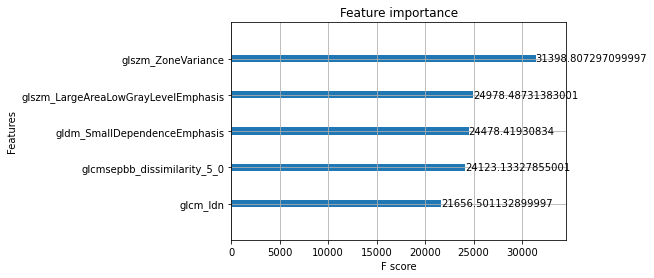

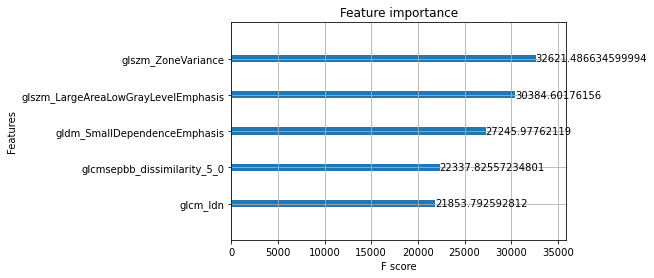

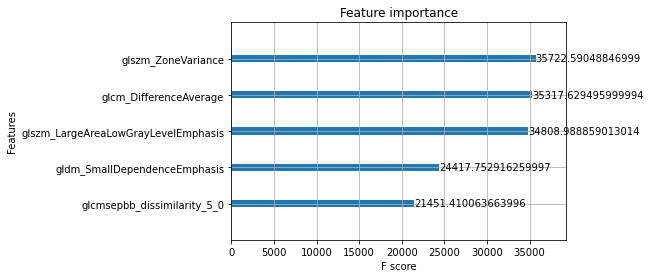

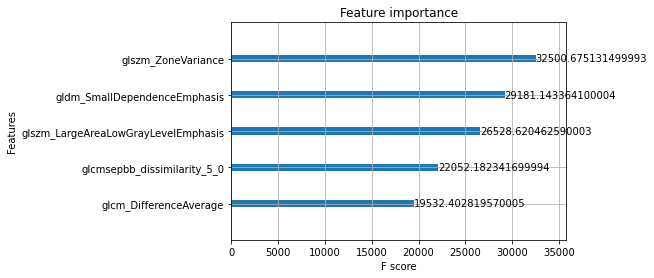

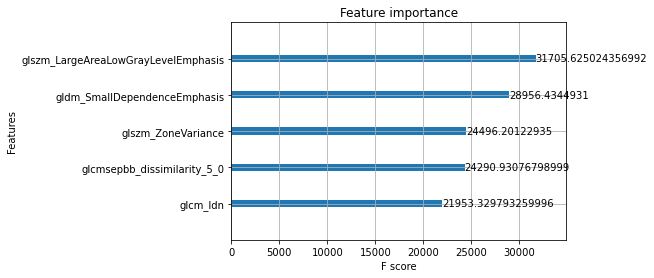

In [131]:
print(X_train_cv.shape)

y2_valid = np.array([])
y2_valid_hat = np.array([])
y2_train = np.array([])
y2_train_hat = np.array([])

k_fold = KFold(5, shuffle=True, random_state=ARG_SEED)
for k, (train, valid) in enumerate(k_fold.split(X_train_cv, y_train_cv)):

    # save best model file per fold
    MODEL_FILE = os.path.join(ARG_SOURCE_PATH, f'models/best-xgboost.model.{k}')
    myCallback = SaveBestModel(MODEL_FILE)
    
    # preseleccion de genes con todos los casos (anteriormente se hizo en la partición de training)
    X_train = X_train_cv.iloc[train]
    y_train = y_train_cv.iloc[train]
    X_valid = X_train_cv.iloc[valid]
    y_valid = y_train_cv.iloc[valid]

    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

    # specify validations set to watch performance
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    results = {}
    bst = xgb.train(param, dtrain, num_boost_round=1000, evals=watchlist, early_stopping_rounds=10, evals_result=results,
                    callbacks=[myCallback], verbose_eval=False)    
    best_iteration = bst.best_iteration
    best_score = bst.best_score
    
    bst = xgb.Booster()  # init model
    bst.load_model(MODEL_FILE)  # load data

    # This is prediction
    y_valid_hat = bst.predict(dvalid)
    y_train_hat = bst.predict(dtrain)
    
    y2_valid = np.concatenate((y2_valid, y_valid))
    y2_valid_hat = np.concatenate((y2_valid_hat, y_valid_hat))
    y2_train = np.concatenate((y2_train, y_train))
    y2_train_hat = np.concatenate((y2_train_hat, y_train_hat))
    
    # correlación entre predichos y observados per fold
    corr_valid = np.corrcoef(y_valid, y_valid_hat)[0, 1]
    corr_train = np.corrcoef(y_train, y_train_hat)[0, 1]
    mae_valid = mean_absolute_error(y_valid, y_valid_hat)
    mae_train = mean_absolute_error(y_train, y_train_hat)
    r2score_valid = r2_score(y_valid, y_valid_hat)
    r2score_train = r2_score(y_train, y_train_hat)

    print("[fold {0}] best iter {1}; best score {2}; PCC ({3:.3f}, {4:.3f}); MAE ({5:.5f}, {6:.5f}); R^2 ({7:.3f}, {8:.3f})".
          format(k, best_iteration, best_score, corr_train, corr_valid, mae_train, mae_valid, r2score_train, r2score_valid))
    
    d = bst.get_fscore() # importance_type='weight'
    # d = bst.get_score(importance_type='gain')
    # d = bst.get_score(importance_type='total_gain')
    # print(f'No. of most important features: {len(d)}')
    xgb.plot_importance(d, max_num_features=5)

    
# correlación entre predichos y observados all folds
corr_valid = np.corrcoef(y2_valid, y2_valid_hat)[0, 1]
corr_train = np.corrcoef(y2_train, y2_train_hat)[0, 1]
mae_valid = mean_absolute_error(y2_valid, y2_valid_hat)
mae_train = mean_absolute_error(y2_train, y2_train_hat)
r2score_valid = r2_score(y2_valid, y2_valid_hat)
r2score_train = r2_score(y2_train, y2_train_hat)

print("\nPCC ({0:.3f}, {1:.3f}); MAE ({2:.5f}, {3:.5f}); R^2 ({4:.3f}, {5:.3f})".
      format(corr_train, corr_valid, mae_train, mae_valid, r2score_train, r2score_valid)) 